In [1]:
from pathlib import Path
from tqdm.notebook import tqdm
from tabulate import tabulate
import random, json
import pycountry
from iso639 import languages
import networkx as nx
from dateutil import parser
from datetime import datetime
from collections import Counter
from langdetect import detect
from omnibelt import load_json, save_json
import Levenshtein
from unidecode import unidecode
import unicodedata

In [2]:
from wordcloud import WordCloud
import nltk
from nltk import word_tokenize, pos_tag, ne_chunk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from rake_nltk import Rake
import spacy
# from sklearn.cluster import DBSCAN
# import numpy as np

stop_words = set(stopwords.words('english'))
stop_words.update("'s", '|', 'I', "n't", "`s", "'s", 'n`t')

nlp = spacy.load('en_core_web_md')

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [4]:
lang_clusters = {'en': ['au', 'ca', 'gb', 'ie', 'in', 'my', 'ng', 'nz', 'ph', 'sa', 'sg', 'us', 'za'],
				 'es': ['ar', 'co', 'cu', 'mx', 've'], 'de': ['at', 'ch', 'de'], 'fr': ['be', 'fr', 'ma'],
				 'zh': ['cn', 'hk', 'tw'], 'ar': ['ae', 'eg'], 'pt': ['br', 'pt'], 'bg': ['bg'], 'cs': ['cz'],
				 'el': ['gr'], 'he': ['il'], 'hu': ['hu'], 'id': ['id'], 'it': ['it'], 'ja': ['jp'], 'ko': ['kr'],
				 'lt': ['lt'], 'lv': ['lv'], 'nl': ['nl'], 'no': ['no'], 'pl': ['pl'], 'ro': ['ro'], 'ru': ['ru'],
				 'sv': ['se'], 'sl': ['si'], 'sk': ['sk'], 'sr': ['rs'], 'th': ['th'], 'tr': ['tr'], 'uk': ['ua']}
loc_names = {'gb': 'United Kingdom', 'ar': 'Argentina', 'pl': 'Poland', 'sk': 'Slovakia', 'us': 'United States',
			 'eg': 'Egypt', 'no': 'Norway', 'ph': 'Philippines', 'at': 'Austria', 'rs': 'Serbia', 'tw': 'Taiwan',
			 'be': 'Belgium', 'cu': 'Cuba', 'sa': 'Saudi Arabia', 'th': 'Thailand', 'id': 'Indonesia',
			 'ru': 'Russian Federation', 'ch': 'Switzerland', 'fr': 'France', 'lt': 'Lithuania', 'tr': 'Turkey',
			 'de': 'Germany', 'cz': 'Czechia', 'pt': 'Portugal', 'ae': 'United Arab Emirates', 'it': 'Italy',
			 'cn': 'China', 'lv': 'Latvia', 'nl': 'Netherlands', 'hk': 'Hong Kong', 'ca': 'Canada', 'br': 'Brazil',
			 'hu': 'Hungary', 'kr': 'Korea', 'si': 'Slovenia', 'au': 'Australia', 'my': 'Malaysia', 'ie': 'Ireland',
			 'ua': 'Ukraine', 'in': 'India', 'ma': 'Morocco', 'bg': 'Bulgaria', 'ng': 'Nigeria', 'il': 'Israel',
			 'se': 'Sweden', 'za': 'South Africa', 've': 'Venezuela', 'nz': 'New Zealand', 'jp': 'Japan',
			 'sg': 'Singapore', 'gr': 'Greece', 'mx': 'Mexico', 'co': 'Colombia', 'ro': 'Romania'}
lang_names = {'en': 'English', 'ko': 'Korean', 'ru': 'Russian', 'es': 'Spanish', 'pt': 'Portuguese', 'cs': 'Czech',
			  'tr': 'Turkish', 'nl': 'Dutch', 'ar': 'Arabic', 'fr': 'French', 'bg': 'Bulgarian', 'id': 'Indonesian',
			  'sk': 'Slovak', 'el': 'Greek', 'he': 'Hebrew', 'sr': 'Serbian', 'hu': 'Hungarian', 'th': 'Thai',
			  'zh': 'Chinese', 'no': 'Norwegian', 'sl': 'Slovenian', 'sv': 'Swedish', 'de': 'German', 'lv': 'Latvian',
			  'pl': 'Polish', 'it': 'Italian', 'ro': 'Romanian', 'lt': 'Lithuanian', 'ja': 'Japanese',
			  'uk': 'Ukrainian'}
cluster_id = {loc: lang for lang, locs in lang_clusters.items() for loc in locs}
len(cluster_id)

54

In [11]:
def show_date(date):
	return date.strftime('%d %b%y')
def get_locs(article):
	return [f'{loc_names[loc]}' for loc in sorted(set(i['location'] for i in article['instances']))]
def get_cats(article):
	return [f'<{cat}>' for cat in sorted(set(i['category'] for i in article['instances']))]
def view_article(art, detailed=False):
	cats = ' '.join(get_cats(art))
	locs = ', '.join(map(repr, get_locs(art)))
	published = parser.parse(art['publishedAt'])
	collected = [parser.parse(i['collectedAt']) for i in art['instances']]
	first = min(collected)
	last = max(collected)
	timing = f'{show_date(first)}' if first == last else f'{show_date(first)} - {show_date(last)}'

	lines = []
	if 'en-title' in art:
		lines.append(f'English Title: {art["en-title"]!r}')
	lines.append(f'{lang_names[art["language"]]} Title: {art["title"]!r}')
	lines.append(f'Categories: {cats}  ---   {locs} ({timing})  ---  {art["source-name"]}')

	if detailed:
		added_desc = False
		desc = art.get('description')
		en_desc = art.get('en-description')
		if en_desc is not None and len(en_desc):
			lines.append(f'English Description: {en_desc}')
			added_desc = True
		elif desc is not None and len(desc):
			lines.append(f'{lang_names[art["language"]]} Description: {desc}')
			added_desc = True
		if not added_desc:
			lines.append(f'- No description -')
	print('\n'.join(lines))

In [6]:
root = Path('/home/fleeb/workspace/local_data/nnn')
recs = (root / 'babel-briefings-v1').glob('**/*.json')
recs = list(recs)
len(recs)
articles = []
for rec in tqdm(recs):
	articles.extend(load_json(rec))
len(articles)

  0%|          | 0/54 [00:00<?, ?it/s]

4719199

In [7]:
by_loc = {}
by_lang = {}
by_source = {}
by_ID = {}
for article in tqdm(articles):
	by_ID[article['ID']] = article
	# article['published'] = parser.parse(article['publishedAt'])
	by_source.setdefault(article['source-name'], []).append(article)
	by_lang.setdefault(article['language'], []).append(article)
	for instance in article['instances']:
		# instance['collected'] = parser.parse(instance['collectedAt'])
		by_loc.setdefault(instance['location'], []).append(article)
len(by_loc), len(by_lang)

  0%|          | 0/4719199 [00:00<?, ?it/s]

(54, 30)

In [8]:
def inst_id(art_id, inst_idx):
	return f'{str(art_id).zfill(7)}-{str(inst_idx).zfill(3)}'
def get_inst(inst_id):
	art_id, inst_idx = inst_id.split('-')
	art = by_ID[art_id]
	inst = art['instances'][int(inst_idx)]
	return {**inst, **art}
def art_row(art):
	return {'aid': art['ID'], 'title': art.get('en-title', art['title']), 'source': art['source-name'],
			'language': art['language']}
def get_title(art):
	return art.get('en-title', art['title'])
def article_title_bag(art):
	title = art.get('en-title', art['title'])
	title_doc = nlp(title)
	key_terms = Counter([token.lemma_.lower() for chunk in title_doc.noun_chunks for token in chunk])
	return key_terms

In [9]:
df = pd.DataFrame(
	[{**row, **inst, 'iid': inst_id(row['aid'], i)} for row in tqdm([art_row(art) for art in articles]) for i, inst in
	 enumerate(by_ID[row['aid']]['instances'])])
df['collectedAt'] = pd.to_datetime(df['collectedAt'])
df = df.sort_values('collectedAt')
df['date'] = df['collectedAt'].dt.date
len(df)

  0%|          | 0/4719199 [00:00<?, ?it/s]

7419089

In [12]:
art = random.choice(articles)
view_article(art, detailed=True)

English Title: 'Good news comes frequently! Shanxi! Shanxi! A large gas field of 100 billion square meters was discovered! - Securities Times'
Chinese Title: '喜讯频传！山西！山西！发现一个千亿方大气田！ - 证券时报'
Categories: <business>  ---   'China' (28 Feb21)  ---  Stcn.com
English Description: CNOOC announced this morning that it successfully discovered a 100-billion-square-meter gas field in Shanxi. Approved by the Ministry of Natural Resources, the proven geological reserves of Shanxi Linxing Gas Field exceed 101 billion cubic meters. The gas field is currently further accelerating exploration and development. Once completed, it will greatly enhance the clean energy supply capacity in North China. According to the plan, CNOOC strives to build the Linxing Gas Field into a large gas field with an annual production capacity of 3.3 billion cubic meters and an annual output of 2.7 billion cubic meters within the next three years. Natural gas from Linxing Gas Field is expected to be transported to Xiongan New

In [13]:
bagowords = {int(ID): bag for ID, bag in load_json(root/'bagowords.json').items()}
# for art in tqdm(articles):
# 	if art['ID'] not in bagowords:
# 		bagowords[art['ID']] = Counter([token.lemma_ for token in nlp(unidecode(art.get('en-title', art['title'])))])
# save_json(bagowords, root/'bagowords.json');
lowords = {ID: {k.lower(): v for k,v in bag.items()} for ID, bag in tqdm(bagowords.items())}
all_bags = lowords
len(bagowords)

  0%|          | 0/4719199 [00:00<?, ?it/s]

4719199

In [14]:
query = 'ahn sang suu kyi'
# query = 'iphone'
query = 'alibaba'
# query = 'myanmar burma coup burmese military ahn sang suu kyi aung san aun'
query = 'ahn sang suu kyi aung san aun myanmar burma burmese'
qdoc = nlp(query)
qtokens = [token.lemma_.lower() for token in qdoc]
qkeys = set(qtokens)
print(qkeys)

{'aung', 'san', 'myanmar', 'burmese', 'kyi', 'aun', 'burma', 'ahn', 'suu', 'sing'}


In [15]:
min_hits = 3
matches = Counter()
for ID, bag in tqdm(all_bags.items()):
	hits = qkeys.intersection([k.lower() for k in bag.keys()])
	if len(hits) and (min_hits is None or len(hits) >= min_hits):
		matches[ID] = len(hits)
# matches = Counter([art['ID'] for art in tqdm(articles) if 'suu kyi' in unidecode(art.get('en-title', art['title']).lower())])
# len(matches)
len(matches)

  0%|          | 0/4719199 [00:00<?, ?it/s]

160

In [16]:
sub = df[df['aid'].isin(matches)]
sub

,aid,title,source,language,collectedAt,location,category,iid,date
6558877,547450,Suu Kyi points out that Myanmar faces 'COVID d...,Dailynews.co.th,th,2020-09-03 06:55:00+00:00,th,general,0547450-000,2020-09-03
426674,1743778,Aung San Suu Kyi: Myanmar democracy icon who f...,Yahoo Entertainment,en,2020-11-06 13:38:00+00:00,sa,general,1743778-000,2020-11-06
426675,1743778,Aung San Suu Kyi: Myanmar democracy icon who f...,Yahoo Entertainment,en,2020-11-06 13:38:00+00:00,us,general,1743778-001,2020-11-06
3353365,1757195,"Despite accusations of genocide, Aung San Suu ...",CNN,en,2020-11-07 11:01:00+00:00,us,general,1757195-000,2020-11-07
426806,1758980,A look at Myanmar's election and Suu Kyi's exp...,Associated Press,en,2020-11-07 11:01:00+00:00,sa,general,1758980-000,2020-11-07
...,...,...,...,...,...,...,...,...,...
2711812,5245848,Myanmar protesters wear flowers to mark Suu Ky...,GMA News,en,2021-06-19 08:29:00+00:00,ph,general,5245848-000,2021-06-19
4726609,5260902,Myanmar protesters wear flowers to mark Suu Ky...,The Sun Daily,en,2021-06-20 11:34:00+00:00,my,general,5260902-000,2021-06-20
4449057,5426173,Myanmar's Aung San Suu Kyi urges people to be ...,CNA,en,2021-06-29 09:06:00+00:00,sg,general,5426173-000,2021-06-29
2728744,6494786,Myanmar junta to put Suu Kyi on trial for corr...,GMA News,en,2021-09-17 11:47:00+00:00,ph,general,6494786-000,2021-09-17


In [17]:
cat = 'language'
grouped_df = sub.groupby(['date', cat]).size().reset_index(name='counts')

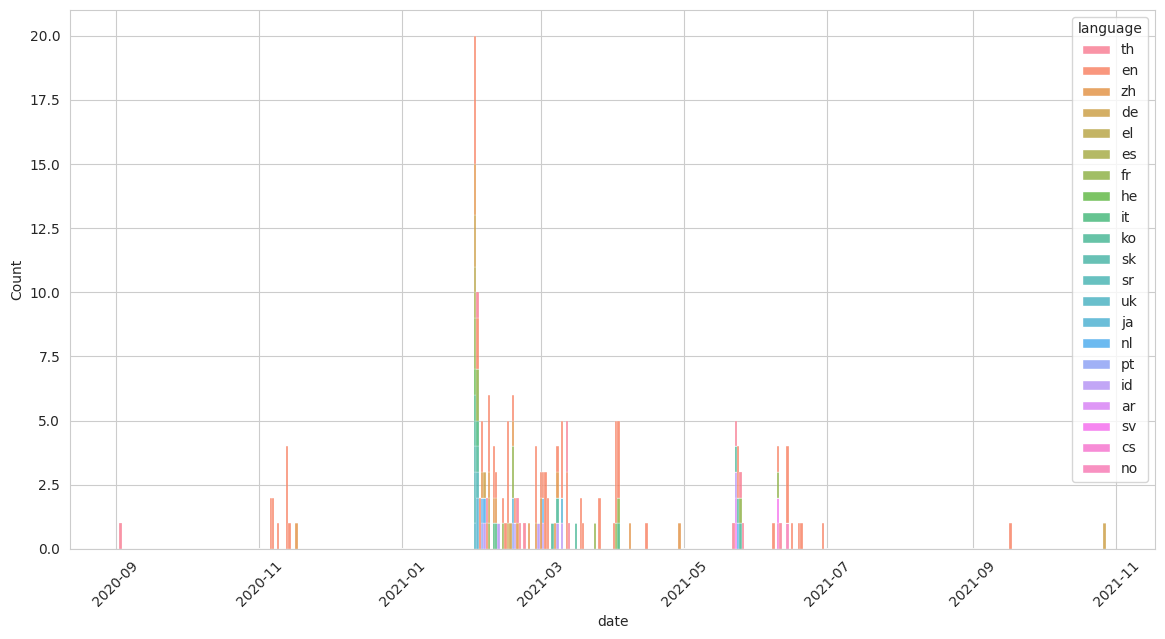

In [18]:
plt.figure(figsize=(14, 7))
sns.histplot(data=grouped_df, x='date', weights='counts', hue=cat, multiple='stack')

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45);

In [19]:
daybags = {}
date_aids = dict(df.groupby('date')['aid'].apply(list))
for date, aIDs in tqdm(sorted(date_aids.items())):
	total = Counter()
	for aID in aIDs:
		total.update(all_bags[aID])
	daybags[date] = total
len(daybags)

  0%|          | 0/413 [00:00<?, ?it/s]

413

In [20]:
deltas = {}
dates = list(daybags.keys())
for d1, d2 in tqdm(zip(dates[:-1], dates[1:]),total=len(dates)-1):
	deltas[d2] = daybags[d2] - daybags[d1]

  0%|          | 0/412 [00:00<?, ?it/s]

In [23]:
target = datetime(2021, 2, 1).date()
# df[df['date'] == target]

In [24]:
dt = deltas[target]
len(dt)

9073

In [25]:
keywords = Counter({w:f for w, f in dt.items() if any(not unicodedata.category(char).startswith('P') for char in w) and w not in stop_words})
len(keywords)

9005

In [440]:
# w, f = keywords.most_common()[0]
# w, f, any(not unicodedata.category(char).startswith('P') for char in w), w not in stop_words

In [26]:
print(tabulate(keywords.most_common(30)))

-------------  --
silver         82
liverpool      75
year           73
february       69
may            60
myanmar        49
international  44
1              43
transfer       42
coup           40
billion        36
eu             36
last           35
name           34
stock          34
science        33
get            33
channel        32
san            29
11             28
high           27
post           27
network        26
million        26
pfizer         26
military       26
investing.com  25
discover       25
speed          25
icloud         25
-------------  --


In [27]:
keywords['aung']

19

In [32]:
token = 'liverpool'
included = [ID for ID, bag in all_bags.items() if token in bag]
len(included)

22947

In [33]:
df[df['aid'].isin(included)][df['date'] == target]

/tmp/ipykernel_848168/4257865151.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['aid'].isin(included)][df['date'] == target]


,aid,title,source,language,collectedAt,location,category,iid,date
5299623,2906047,The pearls of Liverpool's victory - Olé,Olé,es,2021-02-01 14:11:00+00:00,ar,sports,2906047-000,2021-02-01
4428235,2905115,Mark Lawrenson shares his very honest verdict ...,Deepdaledigest.com,en,2021-02-01 14:11:00+00:00,sg,sports,2905115-000,2021-02-01
4428249,2906043,Reasons emerge as Liverpool 'agree fee' for de...,Teamtalk.com,en,2021-02-01 14:11:00+00:00,sg,sports,2906043-000,2021-02-01
4428236,2905160,Transfer expert predicts Liverpool could go to...,Teamtalk.com,en,2021-02-01 14:11:00+00:00,sg,sports,2905160-000,2021-02-01
4428263,2906755,Liverpool agree deal to sign Preston defender ...,CNA,en,2021-02-01 14:11:00+00:00,sg,sports,2906755-000,2021-02-01
...,...,...,...,...,...,...,...,...,...
6340036,2910741,"Liverpool is trying to sign a defender, Sparta...",Sportbox.ru,ru,2021-02-01 14:11:00+00:00,ru,sports,2910741-000,2021-02-01
2021828,2910722,Covers of English newspapers - What did they s...,Filgoal.com,ar,2021-02-01 14:11:00+00:00,eg,sports,2910722-001,2021-02-01
2021827,2910722,Covers of English newspapers - What did they s...,Filgoal.com,ar,2021-02-01 14:11:00+00:00,eg,general,2910722-000,2021-02-01
320745,2910701,Liverpool make emergency reinforcements on the...,Sporting News,ja,2021-02-01 14:11:00+00:00,jp,sports,2910701-000,2021-02-01
